## 9.1 图像增广

1. 概念
    - 图像增广(image augmentation)技术通过对训练图像做一系列随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模
    - 也可理解为:随机改变训练样本可以降低模型对某些属性的依赖，从而提高模型的泛化能力
2. 举例
    - 可以对图像进行不同方式的裁剪，使感兴趣的物体出现在不同位置，从而减轻模型对物体出现位置的依赖性
    - 我们也可以调整亮度、色彩等因素来降低模型对色彩的敏感度

In [1]:
%matplotlib inline
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

import sys
sys.path.append("..") 
import d2lzh_pytorch.utils as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 9.1.1 常用的图像增广方法

In [2]:
d2l.set_figsize()
img = Image.open('../img/cat1.jpg')
#d2l.plt.imshow(img)

In [3]:
# 像素; num_rows * num_cols
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [4]:
# 对输入图像img多次运行图像增广方法aug并展示所有的结果
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

#### 9.1.1.1 翻转和裁剪

通过`torchvision.transforms`创建`RandomHorizontalFlip`实例实现一般概率的图像水平(左右)翻转

```python
torchvision.transforms.RandomHorizontalFlip(p=0.5)
```
- p (float) – probability of the image being flipped. Default value is 0.5

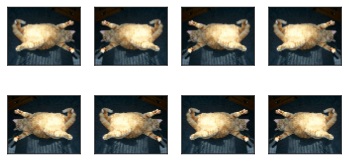

In [5]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

### 对图像随机裁剪来让物体以不同的比例出现在图像的不同位置，这同样能够降低模型对目标位置的敏感性


```python
torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)

```
- size – expected output size of each edge
- scale – range of size of the origin size cropped
- ratio – range of aspect ratio of the origin aspect ratio cropped
- interpolation – Default: PIL.Image.BILINEAR

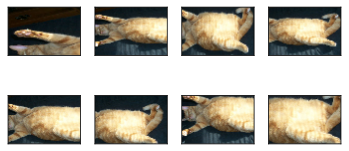

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop((200, 300), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

#### 9.1.1.2 变化颜色

- 亮度（brightness）
- 对比度（contrast）
- 饱和度（saturation）
- 色调（hue）

```python
torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
```
- brightness(亮度)  How much to jitter brightness
- contrast(对比度) How much to jitter contrast.
- saturation(饱和度) How much to jitter saturation
- hue(色调)  How much to jitter hue

 从 [max(0, 1 - arg), 1 + arg],或 [min, max]. 均匀分布中随机获取

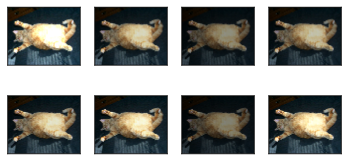

In [7]:
# 亮度
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

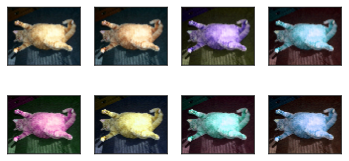

In [8]:
# 色调
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

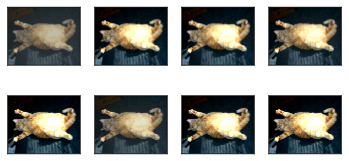

In [9]:
# 对比度
apply(img, torchvision.transforms.ColorJitter(contrast=0.5))

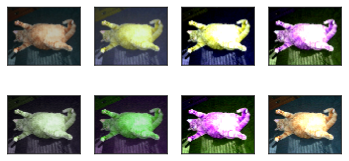

In [10]:
# 同时设置
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

#### 9.1.1.3 叠加多个图像增广方法

通过`Compose`实例将上面定义的多个图像增广方法叠加起来，再应用到每张图像之上

```
torchvision.transforms.Compose(transforms)
```

- transforms (list of Transform objects) – list of transforms to compose.

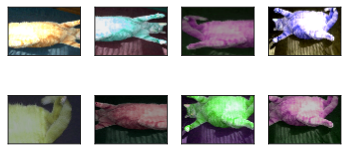

In [11]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

### 9.1.2 使用图像增广训练模型

为了在预测时得到确定的结果，我们通常只将图像增广应用在训练样本上，而不在预测时使用含随机操作的图像增广

Using downloaded and verified file: /Users/tom/Datasets/CIFAR/cifar-10-python.tar.gz
Extracting /Users/tom/Datasets/CIFAR/cifar-10-python.tar.gz to /Users/tom/Datasets/CIFAR


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117bd8208>,
      dtype=object)

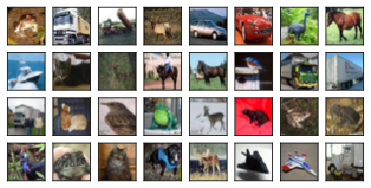

In [12]:
# 每个元素都是(image, label)
all_images = torchvision.datasets.CIFAR10(train=True, root='~/Datasets/CIFAR', download=True)
show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)